1. Chargement des données Fashion-MNIST

In [ ]:
import gzip
import numpy as np

#Fonction de décompression du format zip
def extract_data(filename, num_images):
  with gzip.open('/content/' + filename) as bytestream:
    bytestream.read(16)
    buf = bytestream.read(28 * 28 * num_images)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    data = data.reshape(num_images, 28, 28)
    return data

x_train = extract_data('train-images-idx3-ubyte.gz', 60000)
x_test = extract_data('t10k-images-idx3-ubyte.gz', 10000)

In [ ]:
# Normalisation des images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255 

# vectorisation des images 28x28 en vecteur de 784 coeffs
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


On utilise 70 000 images en niveaux de gris de taille 28x28 qu'on normalise et représente dans un vecteur de taille 784.
Sur ces 70 000 images, il y a :
  * 60 000 images qui vont servir pour l'apprentissage
  * 10 000 images qui vont servir pour le test

2. Autoencodeur avec une seul couche caché

In [ ]:
import keras
from keras import layers

# Taille du code dans l espace latent
taille_code = 32

# Images d ’ entree
input_img = keras.Input(shape=(784,))

#encodeur
encoded = layers.Dense(taille_code, activation='relu')(input_img)

# decodeur
decoded = layers.Dense(784, activation='sigmoid')(encoded)

Ici nous utilisons la fonction relu pour encoder et pour décodé nous utilisons sigmoïd.

2.1 Définition des modèles de l'encodeur et du décodeur

In [ ]:
# Modele pour l ’ autoencodeur
autoencoder = keras.Model(input_img, decoded)

# Modele d’encodeur sur les donnees d’entree pour obtenir le code
encoder = keras.Model(input_img, encoded)

In [ ]:
# Entree du decodeur : code dans l ’ espace latent
encoded_input = keras.Input(shape=(taille_code,))
# Recuperer la derniere couche de l ’ autocodeur
decoded_layer = autoencoder.layers[-1]
# Modele du decodeur
decoder = keras.Model(encoded_input, decoded_layer(encoded_input))

In [ ]:
autoencoder.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 784)]             0         
                                                                 
 dense_15 (Dense)            (None, 32)                25120     
                                                                 
 dense_16 (Dense)            (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


On voit nos trois couches :
* La couche 1 est la couche d'entrée de taille 784, il n'y a aucun paramètre car on a pas encore commencé l'apprentissage
* La couche 2 est la couche cachée de taille 32, l'apprentissage vers cette couche a découvert 25 120 paramètres
* La couche 3 est la couche de sortie de même taille que celle d'entrée, 25 872 paramètres ont été découvert en plus

Au total le réseau de neurone utilise 50 992 paramètres pour décoder les images

2.2 Apprentissage et évaluation de la performance du modèle

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
nepochs=50
autoencoder_train = autoencoder.fit(x_train, x_train, epochs=nepochs, 
                                    batch_size=256, shuffle=True, validation_data=(x_test, x_test))

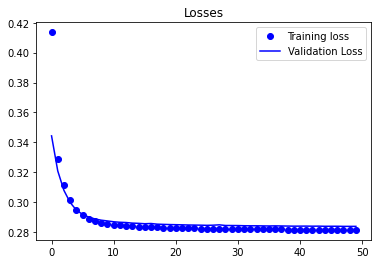

In [ ]:
import matplotlib.pyplot as plt
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(nepochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Losses')
plt.legend()
plt.show()

On voit que le Training loss et notre validation Loss sont quasiment égal notre modèle est donc bien adapté.
Le seul soucis est au début ou le Training loss est bien supérieur à la Validation Loss parce que notre modèle n'est pas encore entrainé, sur la deuxième époque on voit qu'une grosse partie des données à été compressé et on se rapproche d'une égalité. Finalement dès la troisième epochs le modèle est bon.

2.3 Analyse des résultats de l'autoencodage avec le modèle appris

In [ ]:
# Encodage puis decodage des images de tests
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

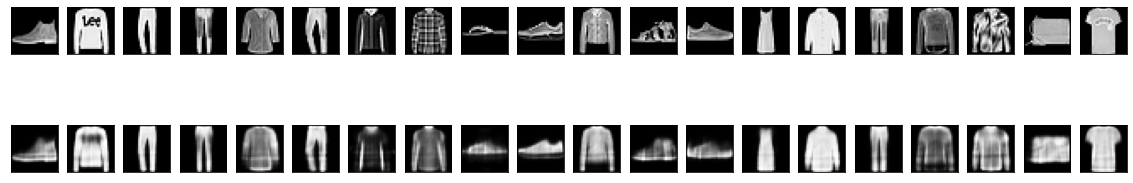

In [ ]:
n = 20
plt.figure(figsize=(20, 4))
for i in range(n):
  # Images originales
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Images decodees
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

On voit l'analyse de notre IA entre les images tests et les images obtenus par notre modèle. Au dessus de 5 il reproduit bien les images. En dessous on retrouve beaucoup d'erreur notamment avec les pulls, au dessus de 20 il n'y a plus aucune erreur.
On peux alors ce dire en regardant la courbe et ces images que le meilleur nombres d'epochs est 2O.

In [ ]:
from skimage.metrics import structural_similarity as ssim 
from sklearn.metrics import mean_squared_error as mse

#on init notre ssim et MSE
my_ssim = np.zeros(encoded_imgs.shape[0])
my_MSE = np.zeros(encoded_imgs.shape[0])
for i in range(x_test.shape[0]):
  my_ssim[i] = ssim(x_test[i], decoded_imgs[i])
  my_MSE[i] = mse(x_test[i], decoded_imgs[i])

{'boxes': [<matplotlib.lines.Line2D at 0x7f5106338990>],
 'caps': [<matplotlib.lines.Line2D at 0x7f510677ba50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5109e21f50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f5109e21ad0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f510677b390>,
  <matplotlib.lines.Line2D at 0x7f510677bd90>]}

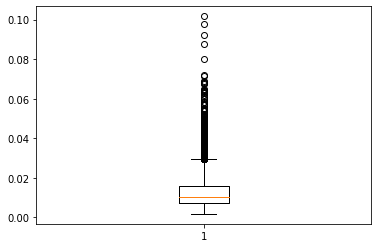

In [ ]:
# mse est un vecteur de flottants
plt.boxplot(my_MSE)

Ici l'on voit notre MSE, nos données étant normalisé entre 0 et 1 on a un tout petit MSE. Un MSE en dessous de 0.1 est bien et au dessus moins bon. En variant le nombre d'epochs on remarque qu'en dessous de 10 le MSE est moins bon passe au dessus de 0.1.

```
# Ce texte est au format code
```



{'boxes': [<matplotlib.lines.Line2D at 0x7f510a4a35d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f510690fa10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f51069e9ad0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f51069e9950>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f510a4a3250>,
  <matplotlib.lines.Line2D at 0x7f510690f890>]}

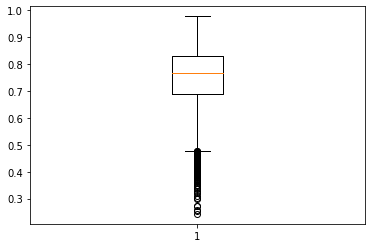

In [ ]:
# ssim est un vecteur de flottants
plt.boxplot(my_ssim)

Le ssim ici est un peu biaisé parce que même avec 3 epochs on a un bon ssim.

2.4 Paramétrage

Avec 20 epochs: on a une bonne validation et Training Loss dès la troisème époque, de plus le ssim et le MSE sont bons

Avec 10 epochs: Les résultats sont identiques à 20 epochs

Avec 5 epochs: Le résultat est bon, on a un bon ssim et un bon MSE. Notre training loss et validation loss sont quasi identique.

Avec 3 epochs: Le training loss est supérieur à la validation Loss, le ssim est potable mais le MSE est trop haut.

Avec 2 epochs: Le résultats est très mauvais, on voit que le training loss est supérieur à la validation Loss. Le ssim est < a 0.8 au minimum et le MSE est haut. Cela montre le manque d'entrainement de notre IA.

Avec 50 epochs: même résultats qu'avec 20

3. Autoencodeur profond

3.1 Définition du modèle

In [ ]:
input_img = keras.Input(shape=(784,))
layer_1 = layers.Dense(128, activation='relu')(input_img)
layer_2 = layers.Dense(64, activation='relu')(layer_1)
encoded = layers.Dense(32, activation='relu')(layer_2)
layer_4 = layers.Dense(64, activation='relu')(encoded)
layer_5 = layers.Dense(128, activation='relu')(layer_4)
decoded = layers.Dense(784, activation='sigmoid')(layer_5)

autoencoder = keras.Model(input_img, decoded)
encoder = keras.Model(input_img, decoded)
decoder = keras.Model(input_img, encoded)
autoencoder.summary()

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 784)]             0         
                                                                 
 dense_29 (Dense)            (None, 128)               100480    
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 dense_31 (Dense)            (None, 32)                2080      
                                                                 
 dense_32 (Dense)            (None, 64)                2112      
                                                                 
 dense_33 (Dense)            (None, 128)               8320      
                                                                 
 dense_34 (Dense)            (None, 784)               101

On voit qu'il y a 7 couches dont 5 qui sont nos hiddens layers.
Nous avons au total 222 384 paramètres utilisé par notre modèle.

3.2  Apprentissage

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
nepochs = 100
autoencoder_train = autoencoder.fit(x_train, x_train, epochs=nepochs, 
    batch_size=256, shuffle=True, validation_data=(x_test, x_test))

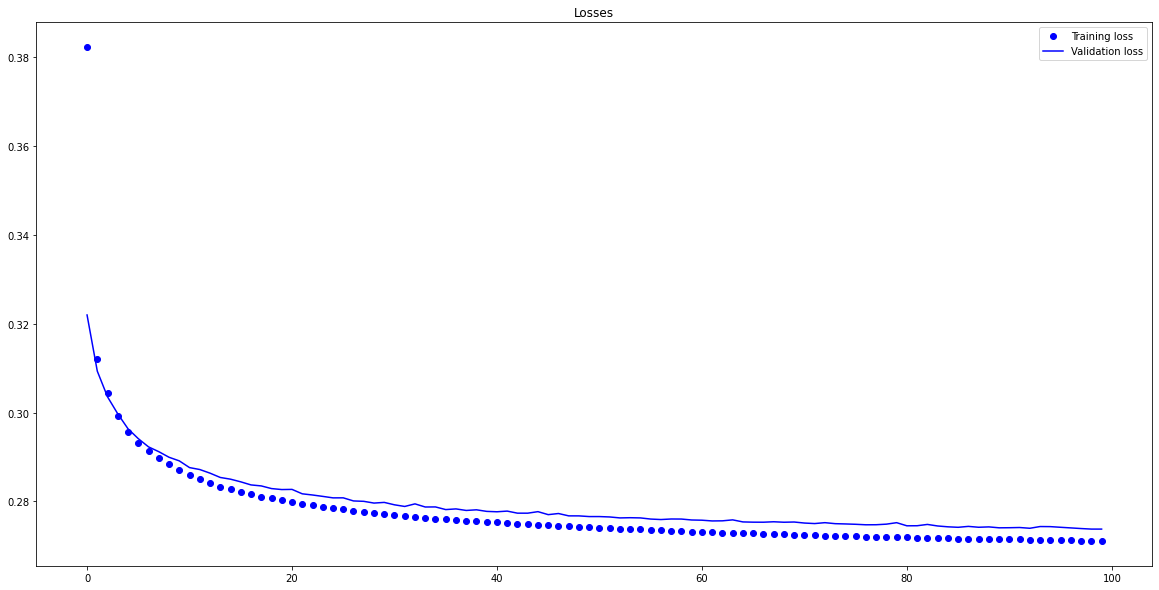

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 20,10

loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(nepochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Losses')
plt.legend()
plt.show()

On voit en comparant notre training loss et validation loos que notre modèle n'est pas adapté, même avec 100 epochs, on voit que le training loss est en dessous de la validation loss. Le modèle est donc à modifier.

3.3 Analyse des résultats de l’autoencodage avec le modèle appris

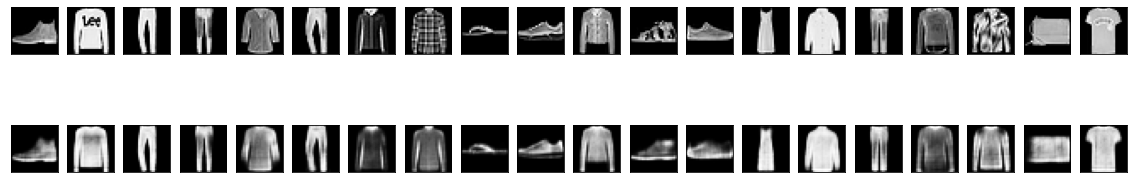

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

n = 20
plt.figure(figsize=(20, 4))
for i in range(n):
    # Images originales
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Images decodees
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

On voit ici que nos images ne sont pas bonnes, beaucoup de pulls sont différents. Le modèle n'arrive pas à reproduire les images de départ.

In [ ]:
my_ssim = np.zeros(encoded_imgs.shape[0])
my_MSE = np.zeros(encoded_imgs.shape[0])
for i in range(x_test.shape[0]):
  my_ssim[i] = ssim(x_test[i], decoded_imgs[i])
  my_MSE[i] = mse(x_test[i], decoded_imgs[i])

{'boxes': [<matplotlib.lines.Line2D at 0x7f50ffbf3810>],
 'caps': [<matplotlib.lines.Line2D at 0x7f50ffc13890>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f50ffbf88d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f50ffbf8390>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f50ffbf3dd0>,
  <matplotlib.lines.Line2D at 0x7f50ffc13350>]}

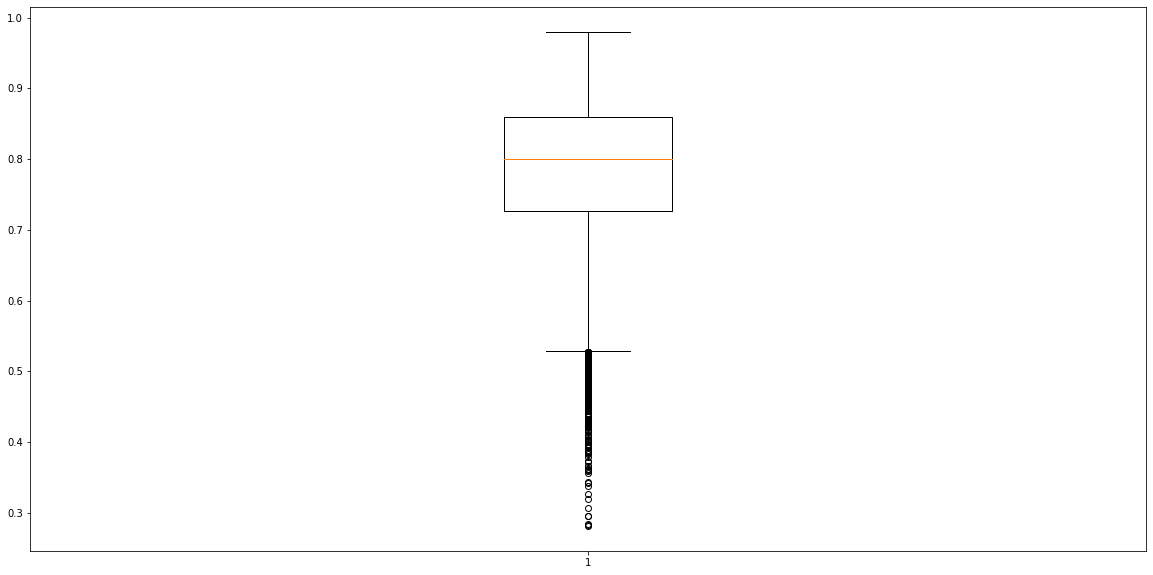

In [ ]:
plt.boxplot(my_ssim)

Le ssim est bon, malgré notre mauvais modèle. On peux alors se dire que le ssim n'est pas une très bonne mesure pour testé notre modèle.

{'boxes': [<matplotlib.lines.Line2D at 0x7f510a045090>],
 'caps': [<matplotlib.lines.Line2D at 0x7f510a0280d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f510a036110>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f510a028b90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f510a045610>,
  <matplotlib.lines.Line2D at 0x7f510a045b50>]}

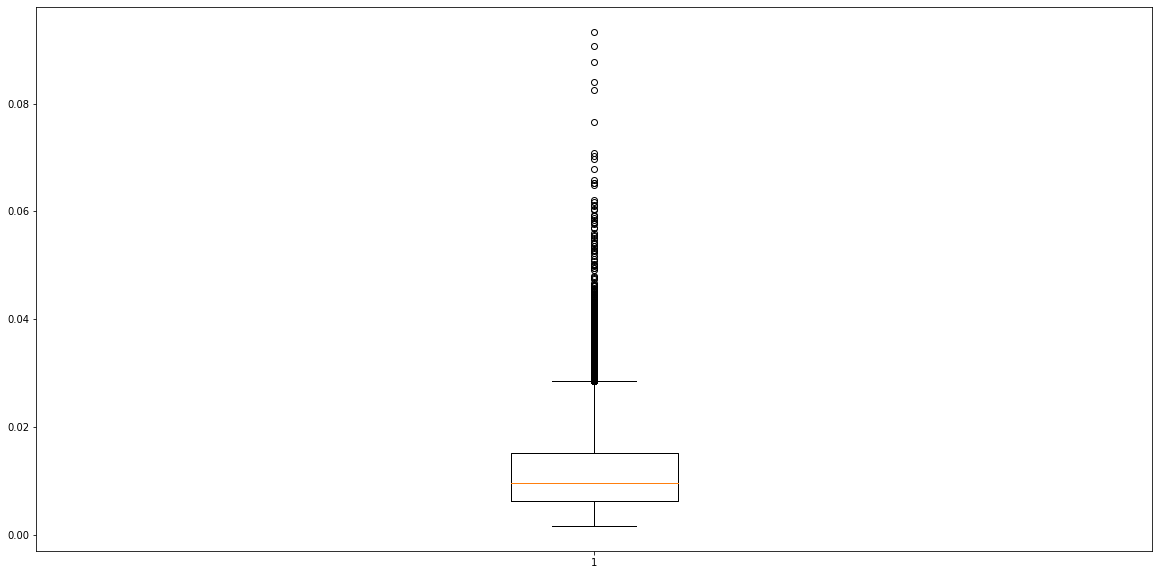

In [ ]:
plt.boxplot(my_MSE)

Le MSE est aussi correct avec un max  à 0.03 ce qui est même extremement bien. A l'oeil nu nos images semble différentes mais le ssim et le MSE les trouve corrects.